In [11]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
species = 'Si'
N = 5
maxdeg = 8
rcut = rcuts[species]
force_name = 'forces'
energy_name = 'energy'
noise = 1e-6

root = f"/home/claudio/postdoc/data/Si_ruggero/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name =energy_name,
#                                             species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

CPU times: user 18.6 ms, sys: 51.6 ms, total: 70.2 ms
Wall time: 8.97 ms
MAE=0.016 RMSE=0.022 SUP=0.080 R2=0.992
MAE=0.167 RMSE=0.230 SUP=3.254 R2=0.929


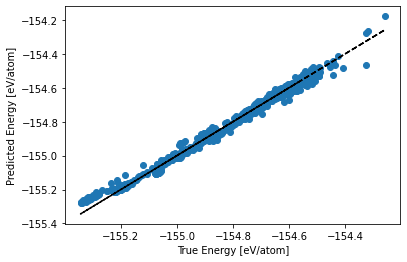

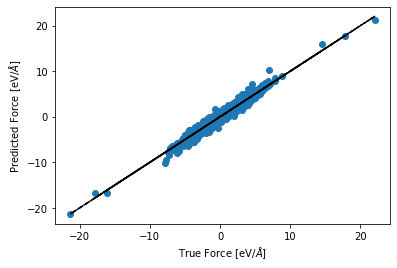

In [47]:
model_lin = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
%time ep, fp = model_lin.predict(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

Using 1 clusters
CPU times: user 242 ms, sys: 65.7 ms, total: 308 ms
Wall time: 193 ms
MAE=0.016 RMSE=0.022 SUP=0.080 R2=0.992
MAE=0.167 RMSE=0.230 SUP=3.254 R2=0.929


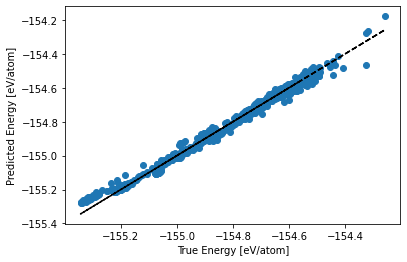

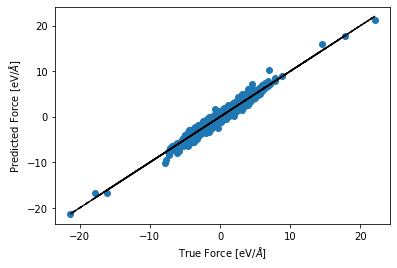

In [56]:
n_clusters = 'auto'
# train the model
model_ens =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                         n_clusters=n_clusters, clustering_type='kmeans')

# evaluate its performances
%time ep, fp = model_ens.predict(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [18]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase import Atoms

In [19]:
calc_lin = ASEMLCalculator(model_lin, model_lin.representation)
calc_ens = ASEMLCalculator(model_ens, model_ens.representation)

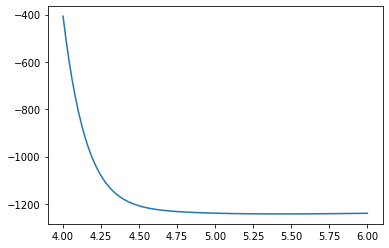

In [20]:
num = 100
en = np.zeros(num)
distances = np.linspace(4.0, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

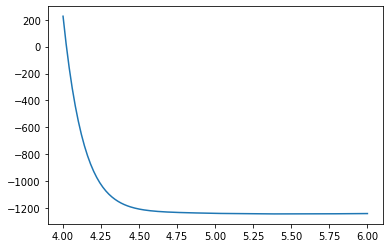

In [21]:
num = 200
en = np.zeros(num)
distances = np.linspace(4, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_ens)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

In [23]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)

In [24]:
# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=5000)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# Now run the dynamics
printenergy(atoms)
for i in range(2000):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -155.353eV  Ekin = 0.506eV (T=3918K)  Etot = -154.847eV
Energy per atom: Epot = -155.107eV  Ekin = 0.260eV (T=2012K)  Etot = -154.847eV
Energy per atom: Epot = -155.178eV  Ekin = 0.330eV (T=2556K)  Etot = -154.847eV
Energy per atom: Epot = -155.128eV  Ekin = 0.281eV (T=2171K)  Etot = -154.847eV
Energy per atom: Epot = -155.095eV  Ekin = 0.247eV (T=1913K)  Etot = -154.847eV
Energy per atom: Epot = -155.200eV  Ekin = 0.349eV (T=2702K)  Etot = -154.851eV
Energy per atom: Epot = -155.003eV  Ekin = 0.157eV (T=1218K)  Etot = -154.846eV
Energy per atom: Epot = -155.110eV  Ekin = 0.257eV (T=1985K)  Etot = -154.854eV
Energy per atom: Epot = -155.137eV  Ekin = 0.283eV (T=2189K)  Etot = -154.854eV
Energy per atom: Epot = -155.073eV  Ekin = 0.221eV (T=1706K)  Etot = -154.852eV
Energy per atom: Epot = -155.208eV  Ekin = 0.355eV (T=2745K)  Etot = -154.853eV
Energy per atom: Epot = -155.113eV  Ekin = 0.261eV (T=2023K)  Etot = -154.852eV
Energy per atom: Epot = -155.131eV  Ekin

KeyboardInterrupt: 